# General Analysis plots for a cosmological simulation with halo data already extracted. 

In [1]:
%load_ext autoreload
%autoreload 1

import yt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from HaloData import *

dataset_fname  = "test_data/RD0009/RD0009"
halo_dat_fname = "test_data/halo_test.dat"
halo_dat2_fname = "test_data/halo_test_many_halos.dat"

hd_small = HaloData.load_from_file(halo_dat_fname)
hd = HaloData.load_from_file(halo_dat2_fname)

In [2]:
def DarkMatter(pfilter, data):
    filter = data[("all", "particle_type")] == 1 # DM = 1, Stars = 2
    return filter
    
yt.add_particle_filter("dark_matter", function=DarkMatter, filtered_type='all', \
                    requires=["particle_type"])

def stars(pfilter, data):
    filter = data[("all", "particle_type")] == 2 # DM = 1, Stars = 2
    return filter

yt.add_particle_filter("stars", function=stars, filtered_type='all', \
                       requires=["particle_type"])

ds = yt.load(dataset_fname)
ds.add_particle_filter('stars')
ds.add_particle_filter('dark_matter')
ad = ds.all_data()
(ad.right_edge-ad.left_edge).to('Mpc')

yt : [INFO     ] 2020-05-11 16:32:11,171 Parameters: current_time              = 228.09678799281
yt : [INFO     ] 2020-05-11 16:32:11,172 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-05-11 16:32:11,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-05-11 16:32:11,173 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-05-11 16:32:11,173 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05-11 16:32:11,174 Parameters: current_redshift          = 0.006999007368208
yt : [INFO     ] 2020-05-11 16:32:11,174 Parameters: omega_lambda              = 0.732
yt : [INFO     ] 2020-05-11 16:32:11,174 Parameters: omega_matter              = 0.268
yt : [INFO     ] 2020-05-11 16:32:11,175 Parameters: hubble_constant           = 0.704
Parsing Hierarchy : 100%|██████████| 182/182 [00:00<00:00, 66873.70it/s]
yt : [INFO     ] 2020-05-11 16:32:11,187 Gathering a field list (this may take a moment.)
/home/cj/anaconda3/li

YTArray([45.13861992, 45.13861992, 45.13861992]) Mpc

# Stellar Mass Fraction for 25 Mpc Box at z = 0

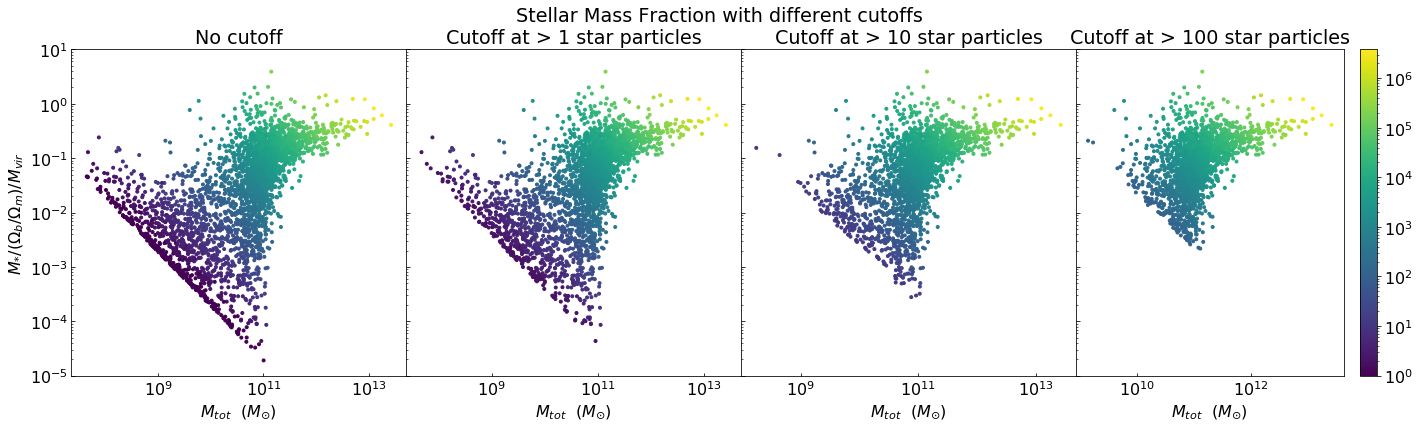

In [3]:
%aimport plots
%aimport HaloData
from plots import *
#stellar_mass_fraction_scatter(halo_dat2_fname, cutoff=0)
stellar_mass_fraction_scatter_multi(hd)
#interact(stellar_mass_fraction_scatter, hd=fixed(hd), cutoff=(0, 1e3));

Stellar Mass Fraction of each halo, plotted against their total mass. The color represents the total number of star particles in each halo. 

# <s>Too many stars?</s>
<s>Not sure why some halos have a stellar mass fraction greater than 1. It might be a dataset mismatch. If it's a dataset mismatch, why are there clear trends to be seen in the graphs? You'd expect it to be basically random.</s> 

Adjusting for cosmological averages gives a stellar mass fraction higher than 1. Behroozi does not calculate stellar mass fractions this way.

It's hard to keep track of which halo catalogs belong to which Enzo dataset. I need to try to figure out some way to keep track of which datasets correspond to which halo catalogs. 



# Data Resolution
It should make sense that the star particle cutoff results in clean, diagonal cuts on the left side of the graph. It might help to plot the stellar mass vs halo mass with number of star particles as well next to this graph just to help me make sense of things. It might be worth looking into doing a vertical cut at ~$10^{10}$ stellar masses. The justification for this being that the mass resolution for these halos is low, thus the data are less trustworthy. Need to confirm this and come up with a formula to determine a proper cutoff mass. 



# Formula used to calculate stellar mass fraction:
$$
f = \frac{M_*}{\displaystyle \frac{\Omega_b}{\Omega_m} M_h}
$$

where
$M_*$ is total stellar mass in a halo

$\Omega_b$ is the cosmological baryon fraction

$\Omega_c$ is the cosmological (cold) dark matter fraction

$\Omega_m = \Omega_b + \Omega_c$

$M_h$ is the halo mass. Note: make sure we calculate halo mass the same way Behroozi does in Behroozi et al (2013)


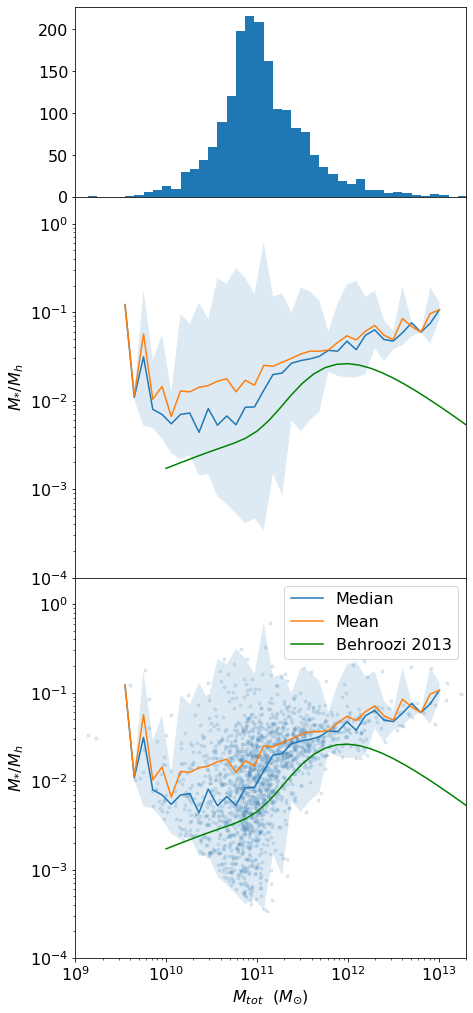

0.006999007368208

In [11]:
# Placeholder for Histogram Code
%aimport plots
from plots import *
cut = 100
#halo_mass_histogram(hd, cutoff=cut)
path = '../Behroozi_2013_data/release-sfh_z0_z8_052913/smmr/'
filefmt = 'c_smmr_z%s_red_all_smf_m1p1s1_bolshoi_fullcosmos_ms.dat'
data_file = path+filefmt % '0.10'
stellar_mass_fraction_reduced(hd, data_file, cutoff=cut)
ds.current_redshift

Top: The histogram of all halos binned by halo mass using $\sqrt{N}$ bins where $N$ is the number of halos. 

Middle: The solid line shows the median stellar mass fraction in each bin. The shaded region is the fill between the maximum and minimum values in each bin. I've also included the data from Behroozi 2013 for comparison. 

Bottom: Same as the middle, except with all the halos plotted over. 

Note: The Behroozi overplot is a median stellar mass fraction at $z = 0.1$, whereas this simulation output is at $z = 0.007$, a time difference of 1.2 Gyr.

Removing the $\Omega_b/\Omega_m$ adjustment factor brings the stellar mass fractions back below 1 and match much more strongly with Behroozi's fit function. 
The overall trend seems to match expectations in the mass range where the simulation is well-resolved (although I still need to quantify what "well-resolved" means), but there's an obvious gap in between the Enzo median and Behroozi's median. One good place to check is how the halo mass is being calculated. Currently I'm using rockstar's halo virial mass as the halo mass and since rockstar was written by Behroozi I'd expect that the definition of halo mass is basically the same, but its worth checking out regardless, just to make sure. 

The gap might also be explained by the different redshifts. The trend in Behroozi's data has the curve moving steadily towards the right over time until $z=3.00$ at which point the curve moves back towards the right. I think with some effort I could fit Behroozi's scale parameter to his data and generate a fit for the actual redshift value, although this might not be all that accurate if the scale parameter changes depending on redshift. 

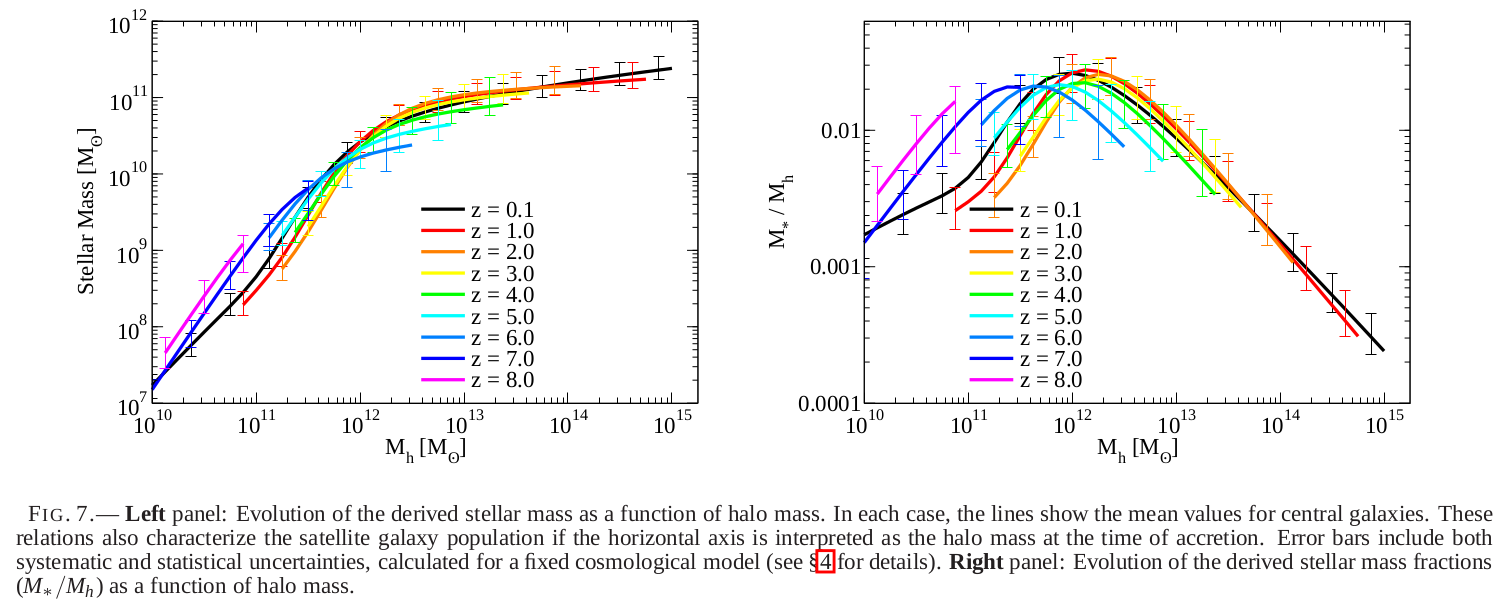

Behroozi describes his fit function as giving the *median* stellar mass for a given halo mass, but the caption in the image says that it gives the *mean* stellar mass. The data files themselves don't say one way or the other.

yt : [INFO     ] 2020-05-11 16:32:18,555 Projection completed
yt : [INFO     ] 2020-05-11 16:32:18,556 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:18,556 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:18,557 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:18,558 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:18,559 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-05-11 16:32:19,160 Projection completed
yt : [INFO     ] 2020-05-11 16:32:19,161 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:19,162 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:19,162 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:19,163 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:19,163 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


Annotating halos...


100%|██████████| 45/45 [00:00<00:00, 94893.76it/s]



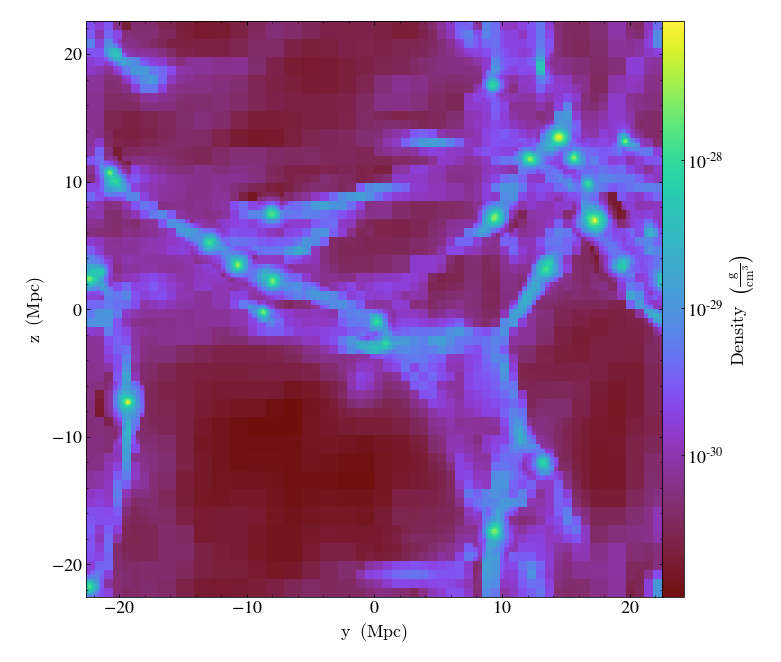


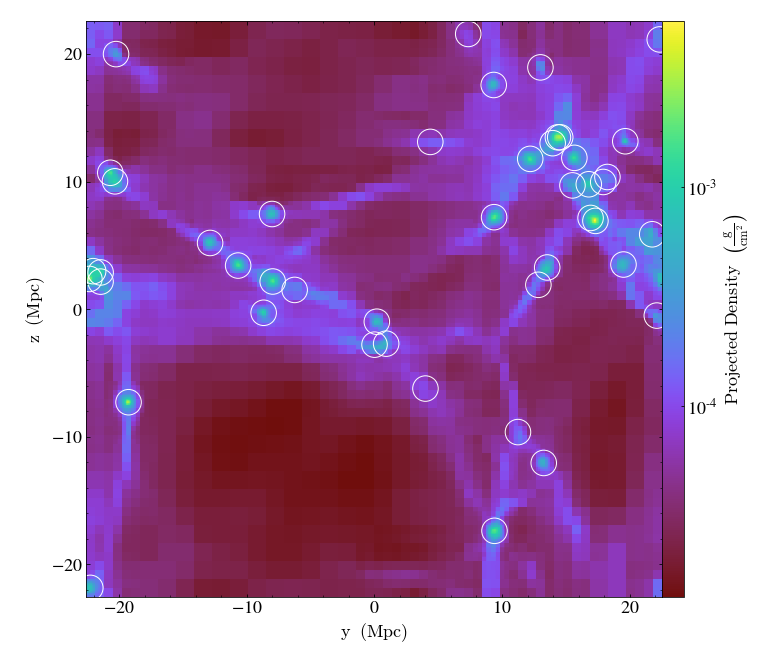

In [6]:
%aimport plots
from plots import *
p = yt.ProjectionPlot(ds, 'x', "density", weight_field='temperature')
hal = projection_w_halos(ds,hd_small, 'density')

p.show()
hal.show()

yt : [INFO     ] 2020-05-11 16:32:20,119 Projection completed
yt : [INFO     ] 2020-05-11 16:32:20,119 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,119 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,120 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,120 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,121 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-05-11 16:32:20,260 Projection completed
yt : [INFO     ] 2020-05-11 16:32:20,260 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,261 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,261 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,262 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:20,263 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



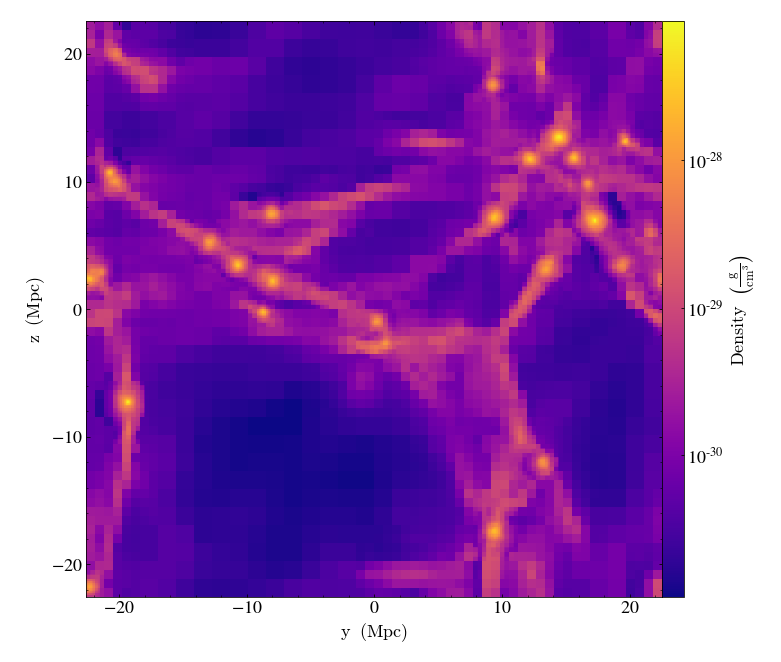


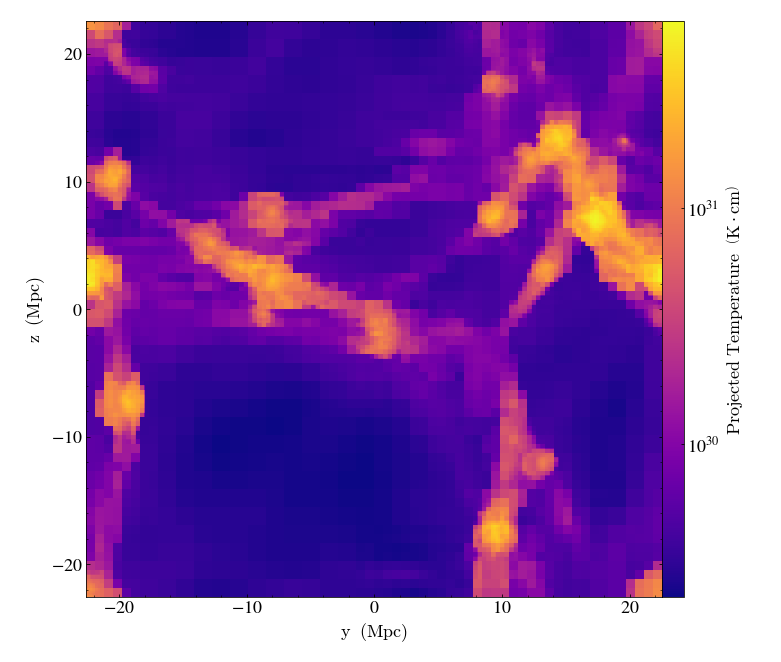

In [7]:
p = yt.ProjectionPlot(ds, 'x', "density", weight_field='temperature')
p.set_cmap('density', cmap='plasma')
temp = yt.ProjectionPlot(ds, 'x', "temperature")
temp.set_cmap('temperature', cmap='plasma')

p.show()
temp.show()

yt : [INFO     ] 2020-05-11 16:32:21,725 Projection completed
yt : [INFO     ] 2020-05-11 16:32:21,725 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,726 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,727 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,728 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,729 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-05-11 16:32:21,949 Projection completed
yt : [INFO     ] 2020-05-11 16:32:21,949 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,949 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,950 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,950 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-11 16:32:21,951 Making a fixed resolution buffer of (('gas', 'metallicity')) 800 by 800



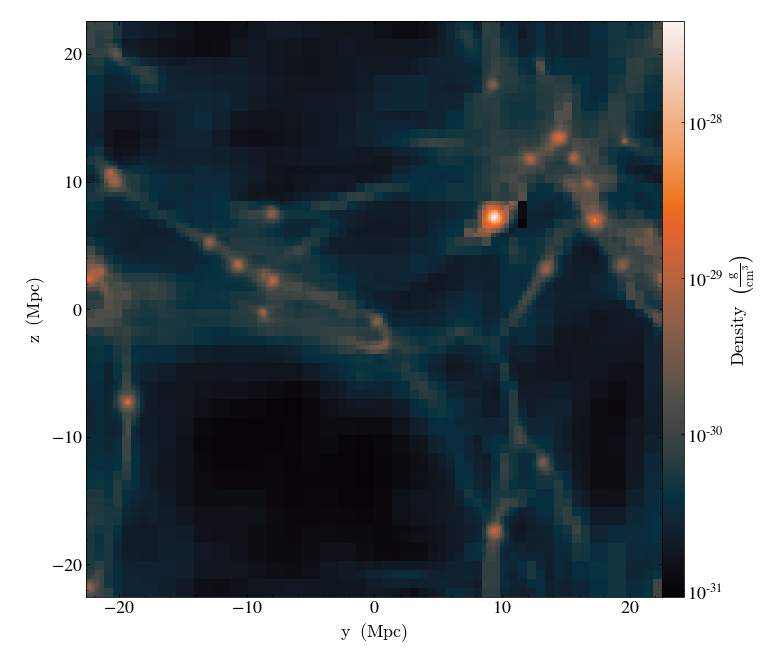


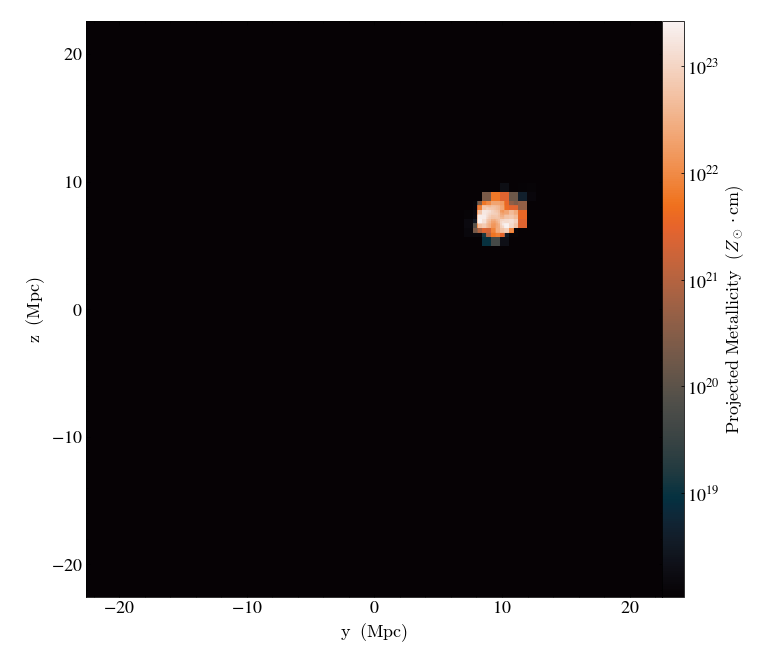

In [8]:
%aimport plots
from plots import *
p = yt.ProjectionPlot(ds, 'x', "density", weight_field='metallicity')
p.set_cmap('density', cmap='dusk')
metal = yt.ProjectionPlot(ds, 'x', "metallicity")
metal.set_cmap('metallicity', cmap='dusk')

p.show()
metal.show()


Metallicity is set to a small ($\sim10^{-20}$) value in the initial conditions, which is why the metallicity around non-star forming regions is not zero. Since the value is the same everywhere, it represents the same fractional value of the density. So weighting by metallicty in regions that are not star-forming is effectively identical to weighting by density. 